# Assignment 2 (Data Science and Decision Making)

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [50]:
# Loaded the preprocessed data
processed = pd.read_csv(r'Stress-Predict-Dataset-main/Processed_data/Improved_All_Combined_hr_rsp_binary.csv')

##### This code reads the data from multiple CSV files that are stored in sub-directories (S02 to S35) in the specified directory (dir_path). Each CSV file corresponds to different physiological measures including ACC (3-axis accelerometer), BVP (blood volume pulse), HR (heart rate), EDA (electrodermal activity) and TEMP (temperature). The data from each CSV file is read into a separate DataFrame, and then merged using the "time" column. The resulting merged DataFrame for each sub-directory is then appended to a list (df_list). After iterating through all sub-directories, the DataFrames in df_list are concatenated into a single DataFrame (concatenated_df). This concatenated DataFrame contains all the data from all sub-directories, and the columns are ordered as 'time', 'x_axis', 'y_axis', 'z_axis', 'bvp', 'temp', 'eda', 'hr'.

In [51]:
# Define the directory path
dir_path = r'Stress-Predict-Dataset-main/Raw_data'

# Create an empty list to store the dataframes
df_list = []

# Loop through the subdirectories S02 to S35
for i in range(2, 36):
    sub_dir = 'S{:02d}'.format(i)
    sub_dir_path = os.path.join(dir_path, sub_dir)

    # Read the csv files into dataframes
    acc_path = os.path.join(sub_dir_path, 'ACC.csv')
    s_acc = pd.read_csv(acc_path)
    new_column_names = {s_acc.columns[0]: 'x_axis', 
                        s_acc.columns[1]: 'y_axis',
                        s_acc.columns[2]: 'z_axis'}
    s_acc.reset_index(inplace=True, drop=True)
    s_acc['time'] = int(float(s_acc.columns[0])) - 1
    s_acc = s_acc.rename(columns=new_column_names)
    s_acc.drop(0, inplace=True)
    s_acc['time'] = s_acc['time'] + s_acc.index

    bvp_path = os.path.join(sub_dir_path, 'BVP.csv')
    s_bvp = pd.read_csv(bvp_path)
    s_bvp.reset_index(inplace=True, drop=True)
    s_bvp['time'] = int(float(s_bvp.columns[0])) - 1
    s_bvp['time'] = s_bvp['time'] + s_bvp.index
    s_bvp = s_bvp.rename(columns={s_bvp.columns[0]: 'bvp'})
    s_bvp.drop(0, inplace=True)

    hr_path = os.path.join(sub_dir_path, 'HR.csv')
    hr = pd.read_csv(hr_path)
    hr.reset_index(inplace=True, drop=True)
    hr['time'] = int(float(hr.columns[0])) - 1
    hr['time'] = hr['time'] + hr.index
    hr.rename({hr.columns[0]: 'hr'}, axis=1, inplace=True)
    hr.drop(0, inplace=True)

    eda_path = os.path.join(sub_dir_path, 'EDA.csv')
    eda = pd.read_csv(eda_path)
    eda.reset_index(inplace=True, drop=True)
    eda['time'] = int(float(eda.columns[0])) - 1
    eda['time'] = eda['time'] + eda.index
    eda.rename({eda.columns[0]: 'eda'}, axis=1, inplace=True)
    eda.drop(0, inplace=True)

    temp_path = os.path.join(sub_dir_path, 'TEMP.csv')
    temp = pd.read_csv(temp_path)
    temp.reset_index(inplace=True, drop=True)
    temp['time'] = int(float(temp.columns[0])) - 1
    temp['time'] = temp['time'] + temp.index
    temp.rename({temp.columns[0]: 'temp'}, axis=1, inplace=True)
    temp.drop(0, inplace=True)

    # Merge the dataframes
    merged_df = s_acc.merge(hr, on='time', how='inner')
    merged_df = merged_df.merge(s_bvp, on='time', how='inner')
    merged_df = merged_df.merge(eda, on='time', how='inner')
    merged_df = merged_df.merge(temp, on='time', how='inner')
    merged_df = merged_df[['time', 'x_axis', 'y_axis', 'z_axis','bvp', 'temp', 'eda', 'hr']]

    
    # Append the merged dataframe to the list
    df_list.append(merged_df)

# Concat the list to make one dataframe
concatenated_df = pd.concat(df_list, axis=0)

In [52]:
concatenated_df

time  x_axis  y_axis  z_axis     bvp   temp       eda      hr
0     1644227584    -8.0    10.0    70.0    0.00  34.79  0.664036  118.00
1     1644227585    -7.0     9.0    63.0    0.01  34.79  0.666599  113.50
2     1644227586    -6.0     9.0    60.0    0.01  34.68  0.669162   93.00
3     1644227587    -5.0     3.0    56.0   -0.00  34.68  0.678132   93.25
4     1644227588    -5.0     0.0    54.0   -0.03  34.68  0.683258   86.40
...          ...     ...     ...     ...     ...    ...       ...     ...
3508  1646842242   -40.0    -4.0    50.0 -358.74  32.99  0.936989   65.37
3509  1646842243   -41.0    -5.0    50.0 -328.67  32.99  0.942114   65.42
3510  1646842244   -41.0    -4.0    50.0 -296.55  32.97  0.943396   65.45
3511  1646842245   -40.0    -4.0    50.0 -261.10  32.97  0.945958   65.47
3512  1646842246   -40.0    -4.0    50.0 -221.45  32.97  0.951084   65.50

[112470 rows x 8 columns]

In [5]:
# Resetting the index
concatenated_df.reset_index(drop=True, inplace=True)

In [6]:
# Setting the name of our column to Time(sec) for later joining with preprocessed data
concatenated_df.rename({concatenated_df.columns[0]:'Time(sec)'}, axis=1 ,inplace=True)

In [7]:
# merge the preprocessed data with the concatenated data
pro_merge = concatenated_df.merge(processed[['Time(sec)','Label']], on='Time(sec)', how='inner')

In [8]:
pro_merge

Time(sec)  x_axis  y_axis  z_axis     bvp   temp       eda      hr  \
0       1644227584    -8.0    10.0    70.0    0.00  34.79  0.664036  118.00   
1       1644227585    -7.0     9.0    63.0    0.01  34.79  0.666599  113.50   
2       1644227586    -6.0     9.0    60.0    0.01  34.68  0.669162   93.00   
3       1644227587    -5.0     3.0    56.0   -0.00  34.68  0.678132   93.25   
4       1644227588    -5.0     0.0    54.0   -0.03  34.68  0.683258   86.40   
...            ...     ...     ...     ...     ...    ...       ...     ...   
164655  1646842242   -40.0    -4.0    50.0 -358.74  32.99  0.936989   65.37   
164656  1646842243   -41.0    -5.0    50.0 -328.67  32.99  0.942114   65.42   
164657  1646842244   -41.0    -4.0    50.0 -296.55  32.97  0.943396   65.45   
164658  1646842245   -40.0    -4.0    50.0 -261.10  32.97  0.945958   65.47   
164659  1646842246   -40.0    -4.0    50.0 -221.45  32.97  0.951084   65.50   

        Label  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
164655      0  
164656      0  
164657      0  
164658      0  
164659      0  

[164660 rows x 9 columns]

In [9]:
# Checking for the duplicates
pro_merge.duplicated().sum()

25812

In [10]:
# Remove duplicates
df_unique = pro_merge.drop_duplicates()

In [11]:
df_unique

Time(sec)  x_axis  y_axis  z_axis     bvp   temp       eda      hr  \
0       1644227584    -8.0    10.0    70.0    0.00  34.79  0.664036  118.00   
1       1644227585    -7.0     9.0    63.0    0.01  34.79  0.666599  113.50   
2       1644227586    -6.0     9.0    60.0    0.01  34.68  0.669162   93.00   
3       1644227587    -5.0     3.0    56.0   -0.00  34.68  0.678132   93.25   
4       1644227588    -5.0     0.0    54.0   -0.03  34.68  0.683258   86.40   
...            ...     ...     ...     ...     ...    ...       ...     ...   
164655  1646842242   -40.0    -4.0    50.0 -358.74  32.99  0.936989   65.37   
164656  1646842243   -41.0    -5.0    50.0 -328.67  32.99  0.942114   65.42   
164657  1646842244   -41.0    -4.0    50.0 -296.55  32.97  0.943396   65.45   
164658  1646842245   -40.0    -4.0    50.0 -261.10  32.97  0.945958   65.47   
164659  1646842246   -40.0    -4.0    50.0 -221.45  32.97  0.951084   65.50   

        Label  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
164655      0  
164656      0  
164657      0  
164658      0  
164659      0  

[138848 rows x 9 columns]

In [12]:
# Checking for 0's and 1's columns in the Label column
df_unique['Label'].value_counts()

0    88545
1    50303
Name: Label, dtype: int64

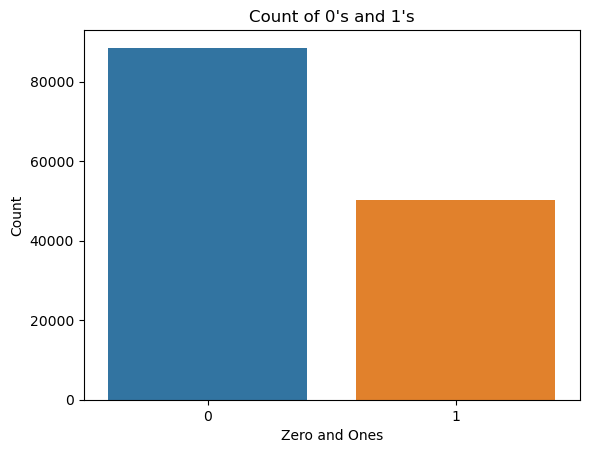

In [13]:
# Visualize 0's and 1's values with countplot and we can see our data is imbalanced
sns.countplot(x='Label', data=df_unique)
# add titles and labels
plt.title("Count of 0's and 1's")
plt.xlabel("Zero and Ones")
plt.ylabel("Count")

# show the plot
plt.show()

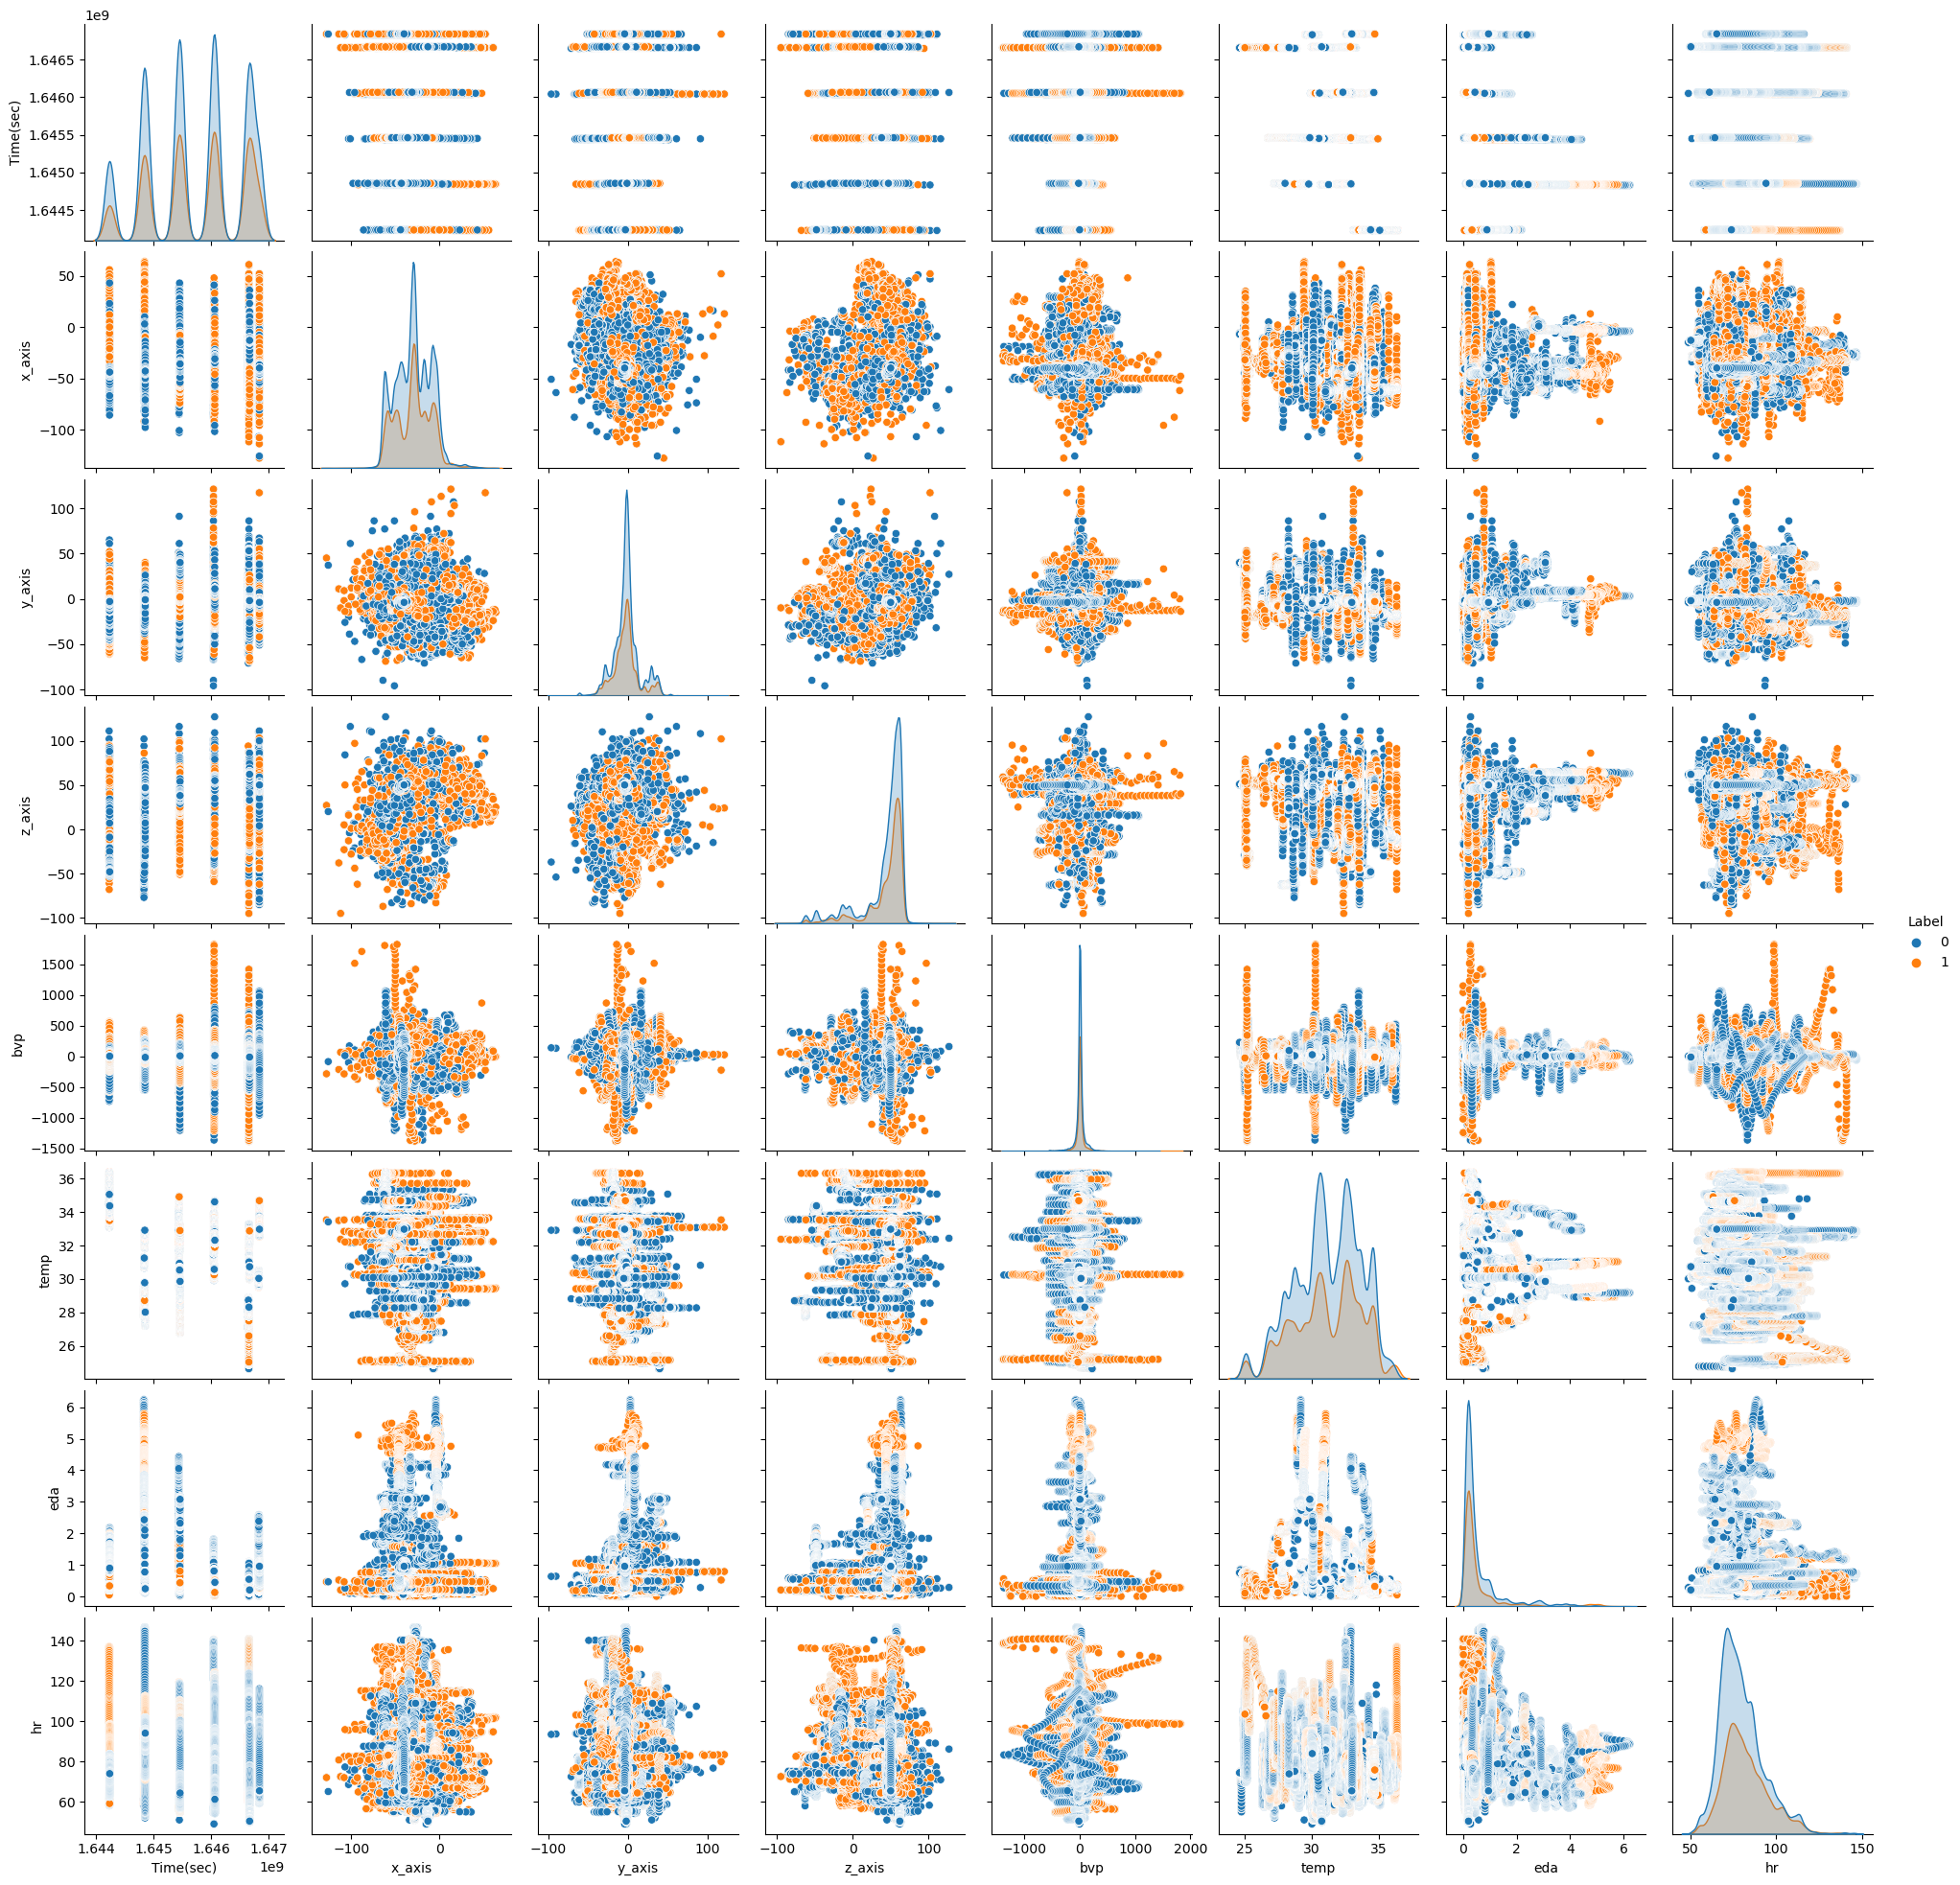

In [14]:
# Pairplot of each column 0's and 1's
sns.pairplot(data=df_unique, hue='Label')
plt.show()

###### This code is performing oversampling on the minority class of the original dataset to address the issue of class imbalance. First, the code separates the features and target variable. Then, it applies the Synthetic Minority Over-sampling Technique (SMOTE) to upsample the minority class. SMOTE is a method that generates synthetic samples of the minority class by creating new samples that interpolate between existing minority class samples. This results in a balanced dataset with an equal number of samples for each class. The upsampled data is then concatenated into a new dataframe with the original column names, creating a new dataset with balanced classes.

In [14]:
# Separate the features and target variable
X = df_unique.drop('Label', axis=1)
y = df_unique['Label']

# Apply SMOTE to upsample the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new dataframe with the upsampled data
df_upsampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
df_upsampled.columns = df_unique.columns

In [15]:
print(df_upsampled['Label'].value_counts())

0    88545
1    88545
Name: Label, dtype: int64


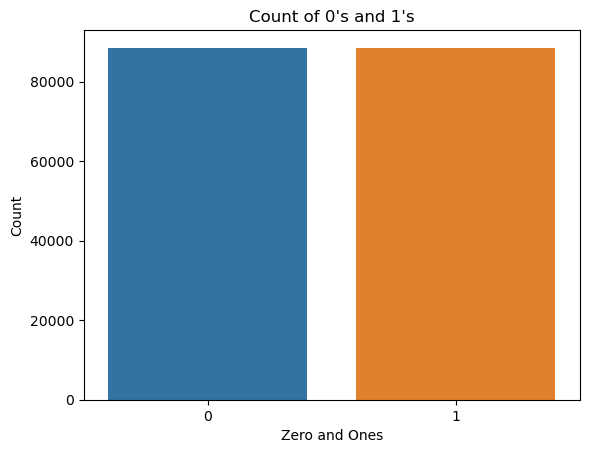

In [16]:
sns.countplot(x='Label', data=df_upsampled)

# add titles and labels
plt.title("Count of 0's and 1's")
plt.xlabel("Zero and Ones")
plt.ylabel("Count")

# show the plot
plt.show()

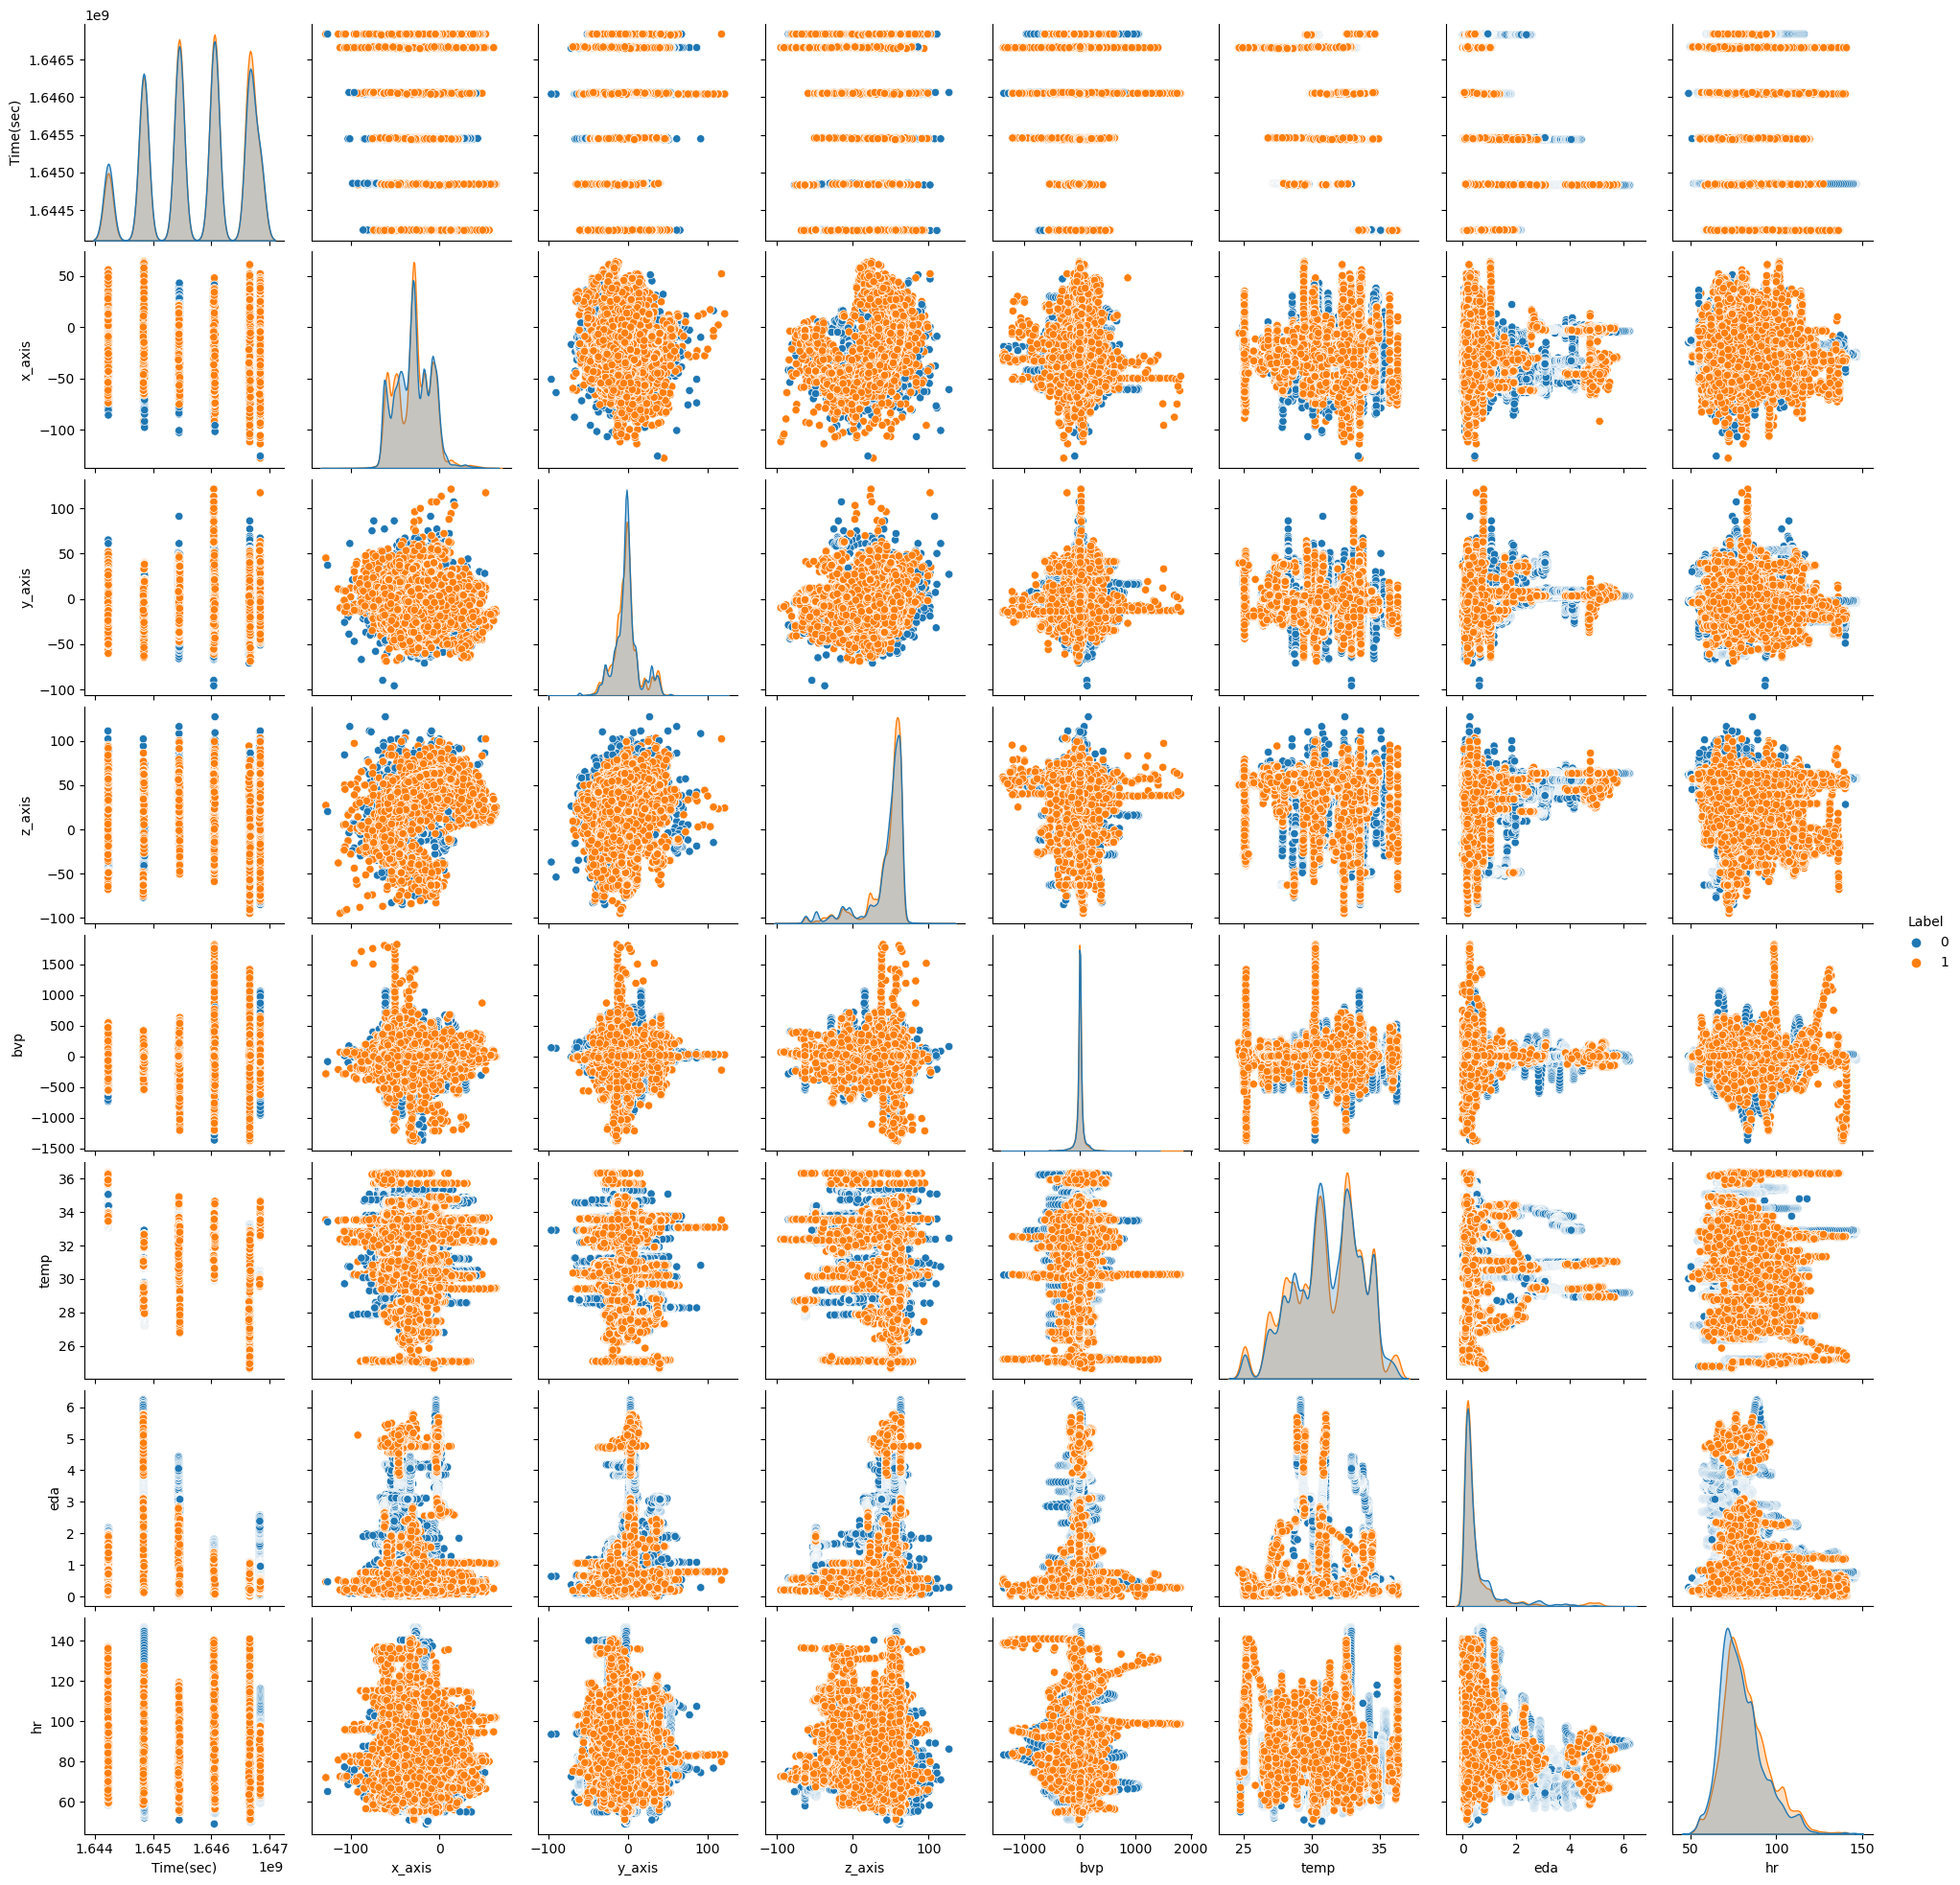

In [19]:
sns.pairplot(data=df_upsampled, hue='Label')
plt.show()

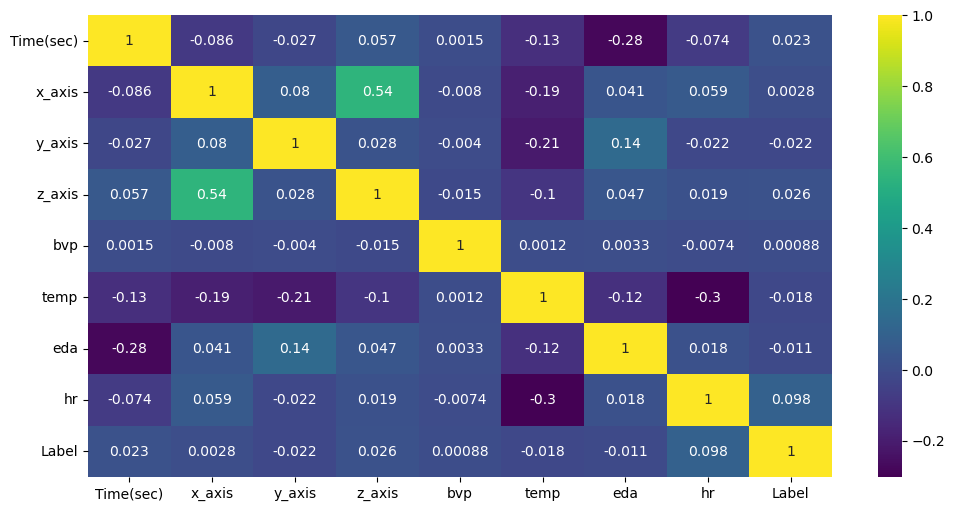

In [17]:
# Visualize the Heatmap with Correlation metrics
plt.figure(figsize=(12, 6))
sns.heatmap(df_upsampled.corr().transpose(), cmap='viridis',annot = True)
plt.show()

<Figure size 1200x600 with 0 Axes>

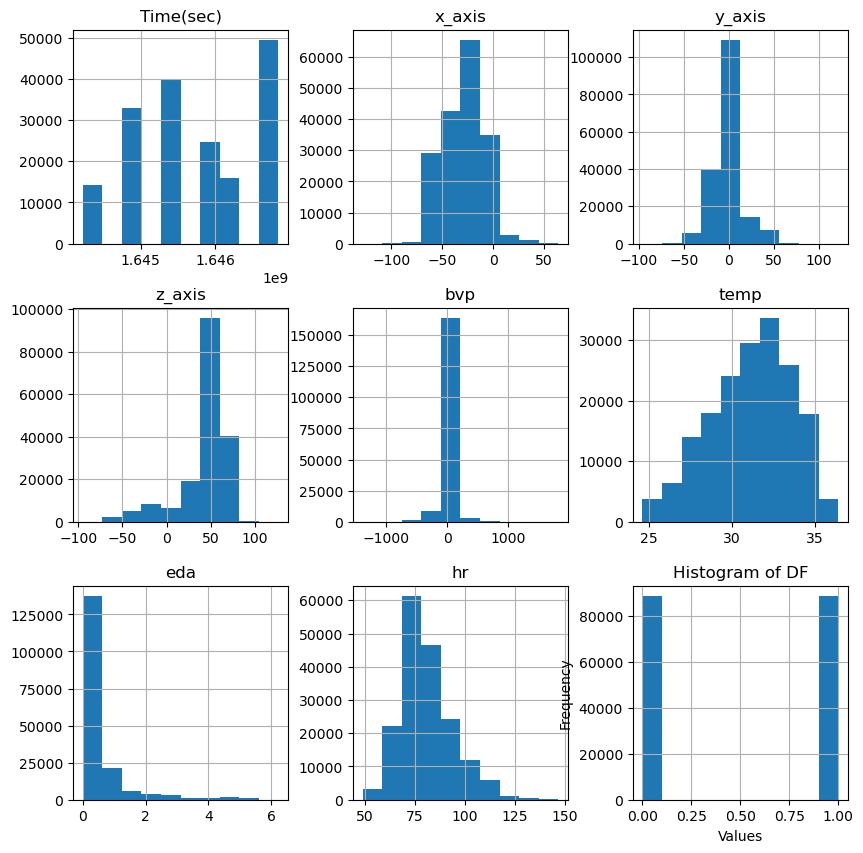

In [18]:
# Checking the histogram of the data
plt.figure(figsize=(12,6))
df_upsampled.hist(figsize=(10, 10))

# add title and labels
plt.title('Histogram of DF')
plt.xlabel('Values')
plt.ylabel('Frequency')

# display plot
plt.show()

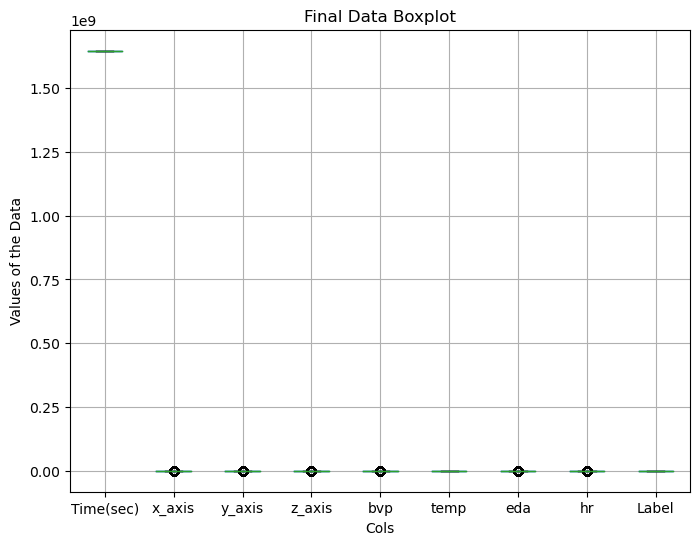

In [19]:
plt.figure(figsize=(8, 6))
df_upsampled.boxplot()
plt.title('Final Data Boxplot')
plt.xlabel('Cols')
plt.ylabel('Values of the Data')
plt.show()

In [48]:
df_upsampled

Time(sec)    x_axis     y_axis     z_axis         bvp       temp  \
0       1644227584  -8.00000  10.000000  70.000000    0.000000  34.790000   
1       1644227585  -7.00000   9.000000  63.000000    0.010000  34.790000   
2       1644227586  -6.00000   9.000000  60.000000    0.010000  34.680000   
3       1644227587  -5.00000   3.000000  56.000000   -0.000000  34.680000   
4       1644227588  -5.00000   0.000000  54.000000   -0.030000  34.680000   
...            ...       ...        ...        ...         ...        ...   
177085  1646658468 -33.00000 -16.035522  56.928955   88.227373  26.085027   
177086  1646053639 -53.07581  31.075810  26.445486   -4.399855  30.570000   
177087  1645444259 -16.00000   1.822239  62.000000  115.759401  30.470000   
177088  1644834245  -9.00000  -5.000000  63.000000   15.065314  28.570000   
177089  1645458459 -51.00000   0.000000  39.000000  374.173056  32.813741   

             eda          hr  Label  
0       0.664036  118.000000      0  
1       0.666599  113.500000      0  
2       0.669162   93.000000      0  
3       0.678132   93.250000      0  
4       0.683258   86.400000      0  
...          ...         ...    ...  
177085  0.006407  123.035985      1  
177086  0.096337   89.762513      1  
177087  0.270377   82.998669      1  
177088  0.208857   71.980000      1  
177089  0.147104   57.913881      1  

[177090 rows x 9 columns]

##### This code is creating a scatter plot using the matplotlib library to visualize the relationship between the 'x_axis' and 'bvp' columns in the df_upsampled dataframe. The 'x_axis' column is a ppg sensor, and the 'bvp' column represents a blood volume pulse signal. The scatter plot shows the relationship between these two variables and can help to identify any patterns or trends in the data.

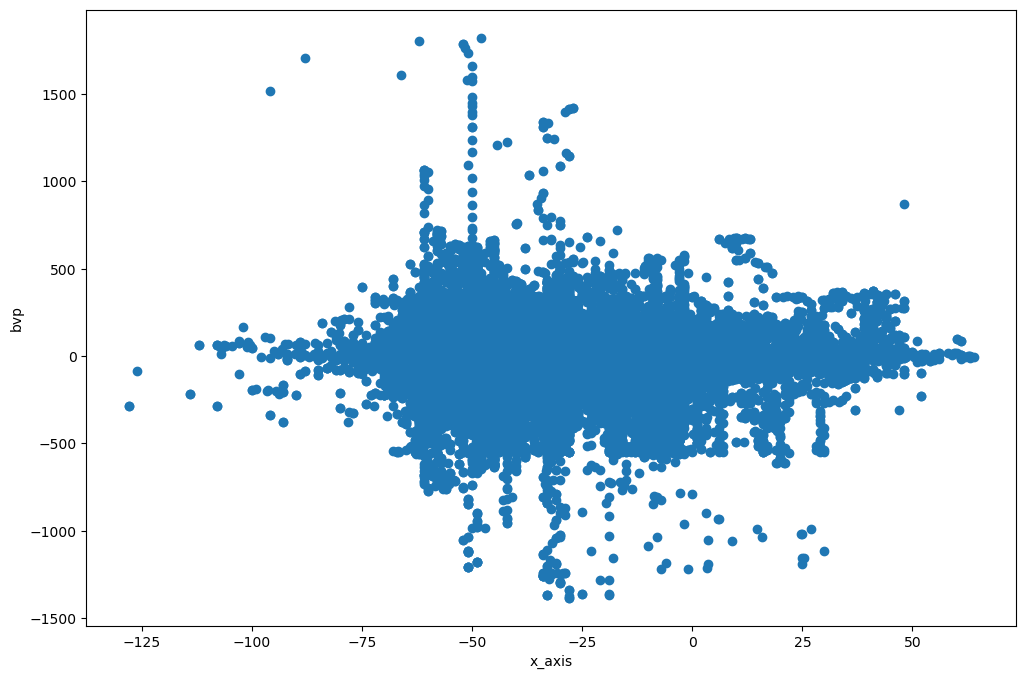

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Visualize the relationship between the x_axis and y_axis columns using a scatter plot
plt.figure(figsize=(12,8))
plt.scatter(df_upsampled['x_axis'], df_upsampled['bvp'])
plt.xlabel('x_axis')
plt.ylabel('bvp')
plt.show()


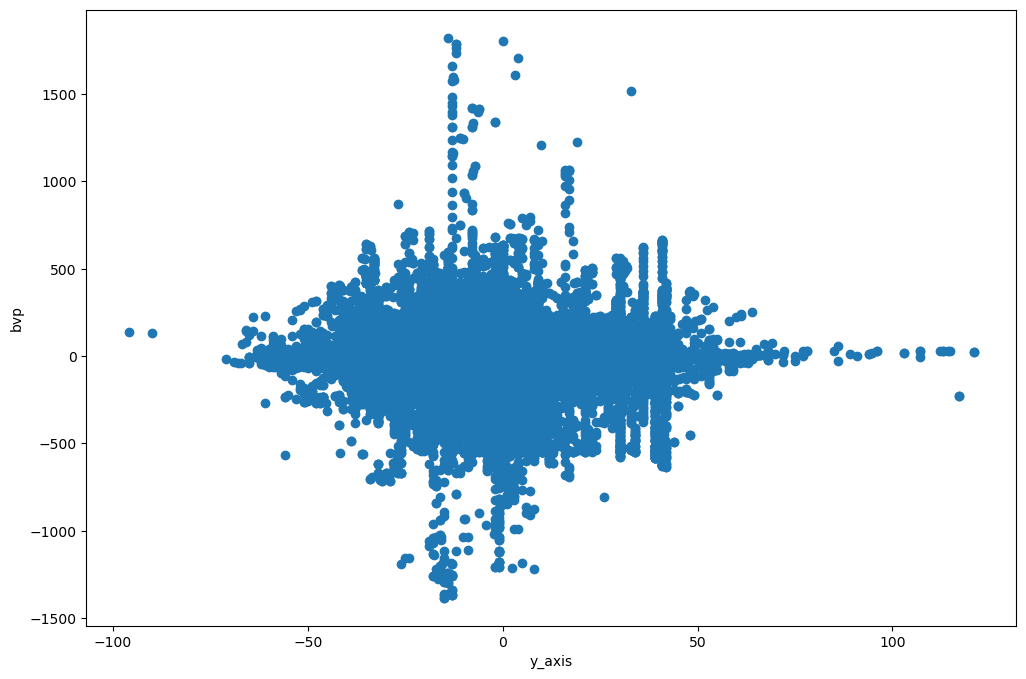

In [21]:
# Visualize the relationship between the x_axis and y_axis columns using a scatter plot
plt.figure(figsize=(12,8))
plt.scatter(df_upsampled['y_axis'], df_upsampled['bvp'])
plt.xlabel('y_axis')
plt.ylabel('bvp')
plt.show()

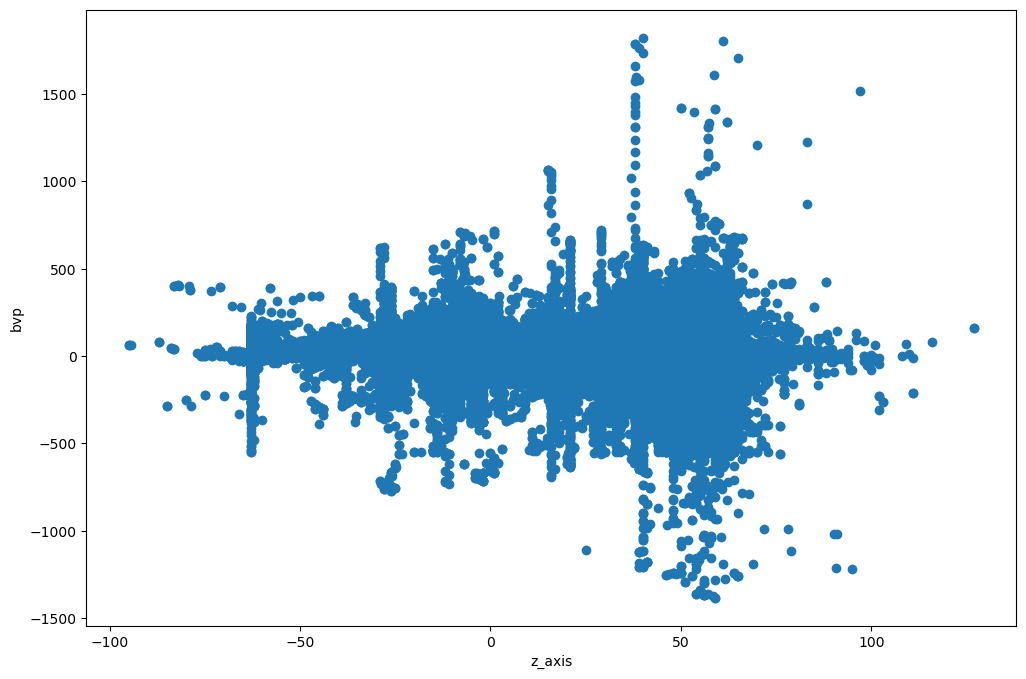

In [22]:
# Visualize the relationship between the x_axis and y_axis columns using a scatter plot
plt.figure(figsize=(12,8))
plt.scatter(df_upsampled['z_axis'], df_upsampled['bvp'])
plt.xlabel('z_axis')
plt.ylabel('bvp')
plt.show()

In [49]:
# create a StandardScaler object
scaler = StandardScaler()

# fit and transform the data
normalized_test_data = scaler.fit_transform(test_df.iloc[:, :-1])

# add the Label column back to the normalized data
normalized_test_data = pd.DataFrame(normalized_test_data, columns=test_df.columns[:-1])
normalized_test_data['Label'] = df_upsampled['Label']

##### This code is creating a Convolutional Neural Network (CNN) model using the Keras API in TensorFlow for binary classification. The data is prepared as sequences of length time_steps with n_features columns, where each row represents a time step and each column represents a feature. First, the data is loaded and the sequences and labels are created from the data. Then, the data is split into training and testing sets using train_test_split() function from sklearn.model_selection. The input data is then reshaped to be compatible with the CNN model. The CNN model architecture consists of one convolutional layer with 32 filters and kernel size of 3, followed by a max pooling layer with a pool size of 2, a flatten layer, and finally a dense output layer with a sigmoid activation function. The model is compiled with the Adam optimizer, binary cross-entropy loss function, and accuracy as the evaluation metric. The model is then trained on the training data for 10 epochs with a batch size of 32 and validation data is set to the testing data. The history of the training process is stored in history variable.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# set the number of time steps and features (columns in your data)
time_steps = 10
n_features = 8

# create sequences of length time_steps from your data
sequences = []
labels = []
for i in range(time_steps, len(normalized_data)):
    sequences.append(normalized_data.iloc[i - time_steps:i, :-1])
    labels.append(normalized_data.iloc[i, -1])
X = np.array(sequences)
y = np.array(labels)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# reshape the input data to be compatible with the CNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))

# create a CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(time_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model to the training data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
4427/4427 [==============================] - 8s 2ms/step - loss: 0.4108 - accuracy: 0.7955 - val_loss: 0.3362 - val_accuracy: 0.8423
Epoch 2/10
4427/4427 [==============================] - 8s 2ms/step - loss: 0.3153 - accuracy: 0.8525 - val_loss: 0.3048 - val_accuracy: 0.8606
Epoch 3/10
4427/4427 [==============================] - 8s 2ms/step - loss: 0.2891 - accuracy: 0.8679 - val_loss: 0.2799 - val_accuracy: 0.8715
Epoch 4/10
4427/4427 [==============================] - 8s 2ms/step - loss: 0.2732 - accuracy: 0.8761 - val_loss: 0.2662 - val_accuracy: 0.8774
Epoch 5/10
4427/4427 [==============================] - 8s 2ms/step - loss: 0.2638 - accuracy: 0.8805 - val_loss: 0.2506 - val_accuracy: 0.8920
Epoch 6/10
4427/4427 [==============================] - 8s 2ms/step - loss: 0.2560 - accuracy: 0.8853 - val_loss: 0.2444 - val_accuracy: 0.8974
Epoch 7/10
4427/4427 [==============================] - 8s 2ms/step - loss: 0.2498 - accuracy: 0.8880 - val_loss: 0.2446 - val_accuracy:

In [33]:
metrices = pd.DataFrame(history.history)
metrices

loss  accuracy  val_loss  val_accuracy
0  0.410800  0.795502  0.336155      0.842303
1  0.315252  0.852538  0.304802      0.860572
2  0.289094  0.867892  0.279860      0.871527
3  0.273241  0.876108  0.266242      0.877400
4  0.263808  0.880485  0.250588      0.892026
5  0.256026  0.885320  0.244409      0.897391
6  0.249794  0.888003  0.244635      0.893212
7  0.244768  0.891793  0.238839      0.895189
8  0.239810  0.893911  0.235108      0.899170
9  0.236002  0.896473  0.235701      0.899029

<Axes: >

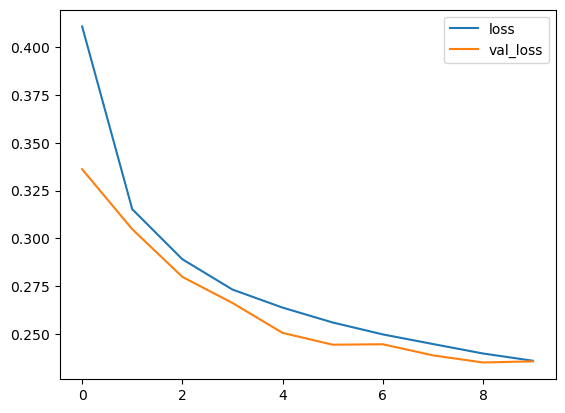

In [34]:
metrices[['loss','val_loss']].plot()

<Axes: >

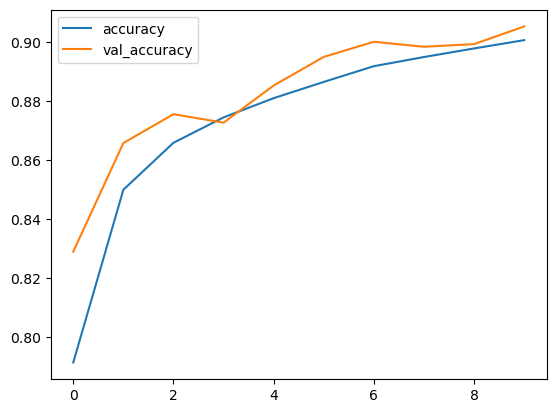

In [44]:
metrices[['accuracy','val_accuracy']].plot()

In [35]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     17684
           1       0.89      0.91      0.90     17732

    accuracy                           0.90     35416
   macro avg       0.90      0.90      0.90     35416
weighted avg       0.90      0.90      0.90     35416

